# Práctico 3 - TSP

## Instalación de Dependencias
Instalación de dependencias requeridad para el experimento

In [2]:
# Install required packages
!pip install numpy matplotlib scipy

## Traveling Salesman Problem (TSP) Ejemplos

Este notebook utilizara matplot lib para ilustrar n ciudades y su solución

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.spatial.distance import pdist, squareform

## Genera un numero random de ciudades

In [4]:
np.random.seed(42)
num_cities = 6
cities = np.random.rand(num_cities, 2) * 100  # 2D coordinates (x, y)
city_labels = [f"Ciudad {i}" for i in range(num_cities)]

## Visualización de ciudades 

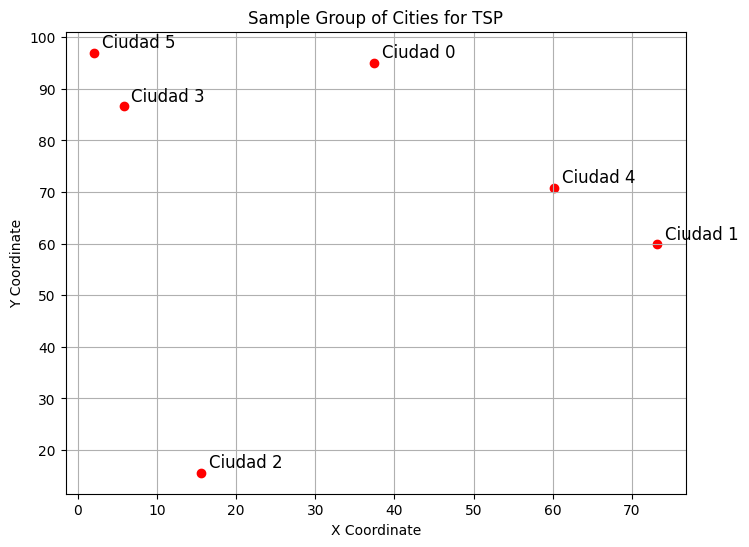

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(cities[:, 0], cities[:, 1], c='red')
for i, (x, y) in enumerate(cities):
    plt.text(x + 1, y + 1, city_labels[i], fontsize=12)
plt.title("Sample Group of Cities for TSP")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

## Algoritmos utilizados y helpers para su implementación

In [6]:
def route_length(route, cities):
    total = 0.0
    for i in range(len(route)):
        start = cities[route[i]]
        end = cities[route[(i+1)%len(route)]]
        total += np.linalg.norm(start - end)
    return total

In [7]:
from typing import List, Tuple, Dict

def brute_force(cities, num_cities,max_iterations: int = 10000) -> Tuple[float, List[int]]:
    routes = list(itertools.permutations(range(num_cities)))
    best_route = min(routes, key=lambda r: route_length(r, cities))
    best_length = route_length(best_route, cities)
    return best_length, best_route


In [8]:
import itertools
import random
import math
from typing import List, Tuple, Dict

class TSPHelper:
    """Helper methods for TSP algorithms.

    This class provides static methods for evaluating tour cost,
    generating neighbors, and reconstructing the optimal path.

    Methods:
        total_distance(tour, dist): Computes the cost of a tour.
        get_neighbors(tour): Generates all neighbors by pairwise swaps.
        random_neighbor(tour): Generates a neighbor by swapping two random cities.
        reconstruct_path(dp, n, last_city): Reconstructs the optimal route from DP table.
    """

    @staticmethod
    def total_distance(tour: List[int], dist: List[List[float]]) -> float:
        """Computes the total cost of a tour, returning to the start.

        Args:
            tour: List of city indices representing the tour.
            dist: 2D distance matrix.

        Returns:
            Total cost (float) of the tour including return to start.
        """
        return sum(dist[tour[i]][tour[(i + 1) % len(tour)]] for i in range(len(tour)))

    @staticmethod
    def get_neighbors(tour: List[int]) -> List[List[int]]:
        """Generates all neighbors of the tour by swapping any two cities.

        Args:
            tour: Current tour as a list of city indices.

        Returns:
            List of neighboring tours (each a list of city indices).
        """
        neighbors = []
        n = len(tour)
        for i in range(n):
            for j in range(i + 1, n):
                neighbor = tour.copy()
                neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                neighbors.append(neighbor)
        return neighbors

    @staticmethod
    def random_neighbor(tour: List[int]) -> List[int]:
        """Generates a neighbor by randomly swapping two cities.

        Args:
            tour: Current tour as a list of city indices.

        Returns:
            Neighboring tour after a random swap.
        """
        a, b = random.sample(range(len(tour)), 2)
        neighbor = tour.copy()
        neighbor[a], neighbor[b] = neighbor[b], neighbor[a]
        return neighbor

    @staticmethod
    def reconstruct_path(dp: Dict[Tuple[int, int], Tuple[float, int]], n: int, last_city: int) -> List[int]:
        """Reconstructs the optimal route from the Held-Karp DP table.

        Args:
            dp: DP table with (subset, last_city) as key and (cost, previous_city) as value.
            n: Number of cities.
            last_city: Last city visited before return to start.

        Returns:
            Optimal tour as a list of city indices (starting and ending at 0).
        """
        path = [0]
        bits = (1 << n) - 2  # All cities except start
        city = last_city
        for _ in range(n - 1):
            path.append(city)
            bits, prev_city = bits & ~(1 << city), dp[(bits, city)][1]
            city = prev_city
        path = path[::-1]
        return path

In [9]:
from scipy.spatial.distance import pdist, squareform

def hill_climbing(cities, num_cities):
    dist = squareform(pdist(cities))
    return hill_climbing_int(dist)

def simulated_annealing(cities, num_cities):
    dist = squareform(pdist(cities))
    return simulated_annealing_int(dist)

def hill_climbing_int(dist: List[List[float]], max_iterations: int = 10_000) -> Tuple[float, List[int]]:
    """Solves the TSP using Hill Climbing local search.

    Starts from a random tour and iteratively moves to the best neighbor
    found by swapping any two cities. Terminates when no improvement is possible.

    Args:
        dist: 2D matrix (n x n) of costs between cities.
        max_iterations: Maximum number of iterations.

    Returns:
        Tuple: (cost of best tour found, tour as list of city indices)
    """
    n = len(dist)
    current_tour = list(range(n))
    random.shuffle(current_tour)
    current_cost = TSPHelper.total_distance(current_tour, dist)

    for _ in range(max_iterations):
        neighbors = TSPHelper.get_neighbors(current_tour)
        neighbor_costs = [TSPHelper.total_distance(neigh, dist) for neigh in neighbors]
        min_cost = min(neighbor_costs)
        if min_cost < current_cost:
            idx = neighbor_costs.index(min_cost)
            current_tour = neighbors[idx]
            current_cost = min_cost
        else:
            break  # Local minimum reached

    return current_cost, current_tour

def simulated_annealing_int(dist: List[List[float]], initial_temp: float = 1000.0,
                        cooling_rate: float = 0.995, max_iterations: int = 10_000) -> Tuple[float, List[int]]:
    """Solves the TSP using Simulated Annealing.

    Starts from a random tour and randomly samples neighbors (by swapping two cities).
    Moves to worse solutions with a probability that decreases with temperature.
    Can escape local minima to find better solutions.

    Args:
        dist: 2D matrix (n x n) of costs between cities.
        initial_temp: Starting temperature for annealing.
        cooling_rate: Rate at which the temperature decreases.
        max_iterations: Maximum number of iterations.

    Returns:
        Tuple: (cost of best tour found, tour as list of city indices)
    """
    n = len(dist)
    current_tour = list(range(n))
    random.shuffle(current_tour)
    current_cost = TSPHelper.total_distance(current_tour, dist)
    best_tour = current_tour[:]
    best_cost = current_cost
    temp = initial_temp

    for _ in range(max_iterations):
        neighbor = TSPHelper.random_neighbor(current_tour)
        neighbor_cost = TSPHelper.total_distance(neighbor, dist)
        delta = neighbor_cost - current_cost
        # Accept neighbor if it improves cost or probabilistically if not
        if delta < 0 or random.random() < math.exp(-delta / temp):
            current_tour = neighbor
            current_cost = neighbor_cost
            if current_cost < best_cost:
                best_tour = current_tour[:]
                best_cost = current_cost
        temp *= cooling_rate
        if temp < 1e-8:
            break

    return best_cost, best_tour


## Helpers para ejecución de pruebas y graficos

In [10]:
def plot_complexity(city_counts, solve_times, algoritm):
    plt.figure(figsize=(8, 6))
    for i, n in enumerate(city_counts):
        plt.scatter(n, solve_times[i], color='blue')
        plt.text(n, solve_times[i], f"{solve_times[i]:.4g}s", fontsize=9, ha='left', va='bottom')
    plt.plot(city_counts, solve_times, marker='o', color='blue')
    plt.title(f"{algoritm.__name__} TSP Time Complexity vs Number of Cities (3 to {len(city_counts)+2})")
    plt.xlabel("Number of Cities")
    plt.ylabel("Computation Time (seconds)")
    plt.grid(True)
    plt.show()

In [11]:
# Defensive mechanism to avoid log(0) underflow for very small times
def plot_log_complexity(city_counts, solve_times,algoritm):
    log_times = [t if t > 0 else 1e-6 for t in solve_times]
    plt.figure(figsize=(8, 6))
    plt.plot(city_counts, log_times, marker='o', color='purple')
    for i, n in enumerate(city_counts):
        plt.text(n, log_times[i], f"{solve_times[i]:.4g}s", fontsize=9, ha='left', va='bottom')
    plt.yscale('log')
    plt.title(f"{algoritm.__name__} TSP Computation Time (Log Scale) vs Number of Cities (3 to {len(city_counts)+2})")
    plt.xlabel("Number of Cities")
    plt.ylabel("Computation Time (seconds, log scale)")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

In [12]:
import time

def run_n_cities(algorithm, max_cities=6, show_plots=True):
    np.random.seed(42)
    initial_cities = np.random.rand(3, 2) * 100
    cities = initial_cities.copy()
    city_labels = [f"City {i}" for i in range(3)]
    solve_times = []
    best_costs = []
    city_counts = list(range(3, max_cities + 1))
    print(city_counts)
    result_rows = []  # (n, route_str, best_length_str, elapsed_str)

    algo_name = getattr(algorithm, "__name__", "algorithm")

    # Sólo preparamos objetos de figura/axes si realmente vamos a plotear
    if show_plots:
        fig = None
        axes = None
        slot_idx = 0
        slots_in_fig = 0

    for i, n in enumerate(city_counts):
        if n > 3:
            # Add one new city
            new_city = np.random.rand(1, 2) * 100
            cities = np.vstack([cities, new_city])
            city_labels.append(f"City {n-1}")

        start_time = time.time()
        best_length, best_route = algorithm(cities, n)
        elapsed = time.time() - start_time

        solve_times.append(elapsed)
        best_costs.append(best_length)

        # progreso corto por problema
        print(f"[{i+1}/{len(city_counts)}] ciudades={n} | tiempo={elapsed:.4f}s | costo={best_length:.2f}")

        # ----------- PLOTEO (opcional) -----------
        if show_plots:
            # subplots de a 3
            if slot_idx == 0:
                remaining = min(3, len(city_counts) - i)
                fig, axes = plt.subplots(1, remaining, figsize=(6 * remaining, 5))
                if remaining == 1:
                    axes = [axes]  # normaliza a lista
                slots_in_fig = remaining

            ax = axes[slot_idx]
            slot_idx += 1

            # puntos y labels
            ax.scatter(cities[:, 0], cities[:, 1])
            for j, (x, y) in enumerate(cities):
                ax.text(x + 1, y + 1, city_labels[j], fontsize=9)

            # ruta
            route_cities = np.array([cities[k] for k in best_route] + [cities[best_route[0]]])
            ax.plot(route_cities[:, 0], route_cities[:, 1], marker='o')

            ax.set_title(f"[{algo_name}] TSP {n} | Costo {best_length:.2f}\nTiempo {elapsed:.4f}s")
            ax.set_xlabel("X")
            ax.set_ylabel("Y")
            ax.grid(True)

            # si llenamos la fila (3) o es el último, mostrar y resetear
            if slot_idx == slots_in_fig or i == len(city_counts) - 1:
                plt.tight_layout()
                plt.show()
                slot_idx = 0  # listo para la próxima figura
        # ----------- FIN PLOTEO -----------

        # guardar para la tabla final
        route_str = "->".join(map(str, best_route))
        result_rows.append((n, route_str, f"{best_length:.2f}", f"{elapsed:.4f}"))

    # --- tabla final: n | ruta | largo | tiempo(s) ---
    headers = ["n", "ruta", "largo", "tiempo(s)"]
    col_widths = [
        max(len(str(h)), *(len(str(r[c])) for r in result_rows))
        for c, h in enumerate(headers)
    ]

    def fmt_row(row):
        return " | ".join(str(val).ljust(col_widths[c]) for c, val in enumerate(row))

    sep = "-+-".join("-" * w for w in col_widths)

    print("\n" + fmt_row(headers))
    print(sep)
    for row in result_rows:
        print(fmt_row(row))

    # gráficos de complejidad sólo si se pidió plotear
    if show_plots:
        plot_complexity(city_counts, solve_times, algorithm)        # agrega título dentro con algo_name si querés
        plot_log_complexity(city_counts, solve_times, algorithm)

    return city_counts, solve_times, best_costs

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator  # para ticks enteros

def plot_algorithms_times_costs(algorithms, max_cities, start_at=3):
    """
    algorithms: lista de funciones [alg1, alg2, ...]
    max_cities: se pasa directo a run_n_cities(...)
    run_n_cities: callable (algorithm, max_cities, show_plots=False) -> (city_counts, solve_times, best_costs)
    start_at: mínimo de ciudades a graficar (por defecto 3)
    """
    series = []  # [(label, x, times, costs), ...]

    for alg in algorithms:
        city_counts, solve_times, best_costs = run_n_cities(alg, max_cities, show_plots=False)

        # filtrar desde start_at
        idxs = [i for i, n in enumerate(city_counts) if n >= start_at]
        x = [city_counts[i] for i in idxs]
        t = [int(solve_times[i]) if float(solve_times[i]).is_integer() else float(solve_times[i]) for i in idxs]
        c = [int(best_costs[i]) if float(best_costs[i]).is_integer() else float(best_costs[i]) for i in idxs]

        label = getattr(alg, "__name__", str(alg))
        series.append((label, x, t, c))

    # --- graficar ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ax_time, ax_cost = axes

    for label, x, t, c in series:
        ax_time.plot(x, t, marker='o', label=label)
        ax_cost.plot(x, c, marker='o', label=label)

    # subplot tiempos
    ax_time.set_title("Tiempo (log) vs. Nº de ciudades")
    ax_time.set_xlabel("Ciudades (n)")
    ax_time.set_ylabel("Tiempo (s)")
    ax_time.set_yscale("log")
    ax_time.xaxis.set_major_locator(MaxNLocator(integer=True))  # ticks enteros
    ax_time.grid(True)
    ax_time.legend()

    # subplot costos
    ax_cost.set_title("Costo vs. Nº de ciudades")
    ax_cost.set_xlabel("Ciudades (n)")
    ax_cost.set_ylabel("Costo de la ruta")
    ax_cost.xaxis.set_major_locator(MaxNLocator(integer=True))  # ticks enteros
    ax_cost.grid(True)
    ax_cost.legend()

    plt.tight_layout()
    plt.show()
    return series



## Algoritmo de Brute-Force  para un numero pequeño de ciudades

In [14]:
best_length, best_route = brute_force(cities, num_cities)
print("Best route:", best_route)
print("Best route length: {:.2f}".format(best_length))

Best route: (0, 4, 1, 2, 3, 5)
Best route length: 241.07


### Representación grafica de Brute-Force

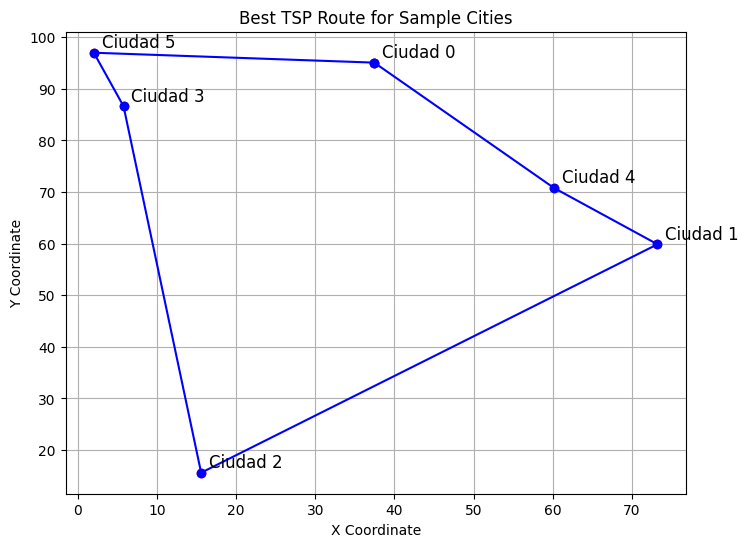

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(cities[:, 0], cities[:, 1], c='red')
for i, (x, y) in enumerate(cities):
    plt.text(x + 1, y + 1, city_labels[i], fontsize=12)

# Draw the route
route_cities = np.array([cities[i] for i in best_route] + [cities[best_route[0]]])
plt.plot(route_cities[:, 0], route_cities[:, 1], 'b-o')

plt.title("Best TSP Route for Sample Cities")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

### Ruta random de TSP para comparación

Random route: [4 2 0 5 1 3]
Random route length: 398.09


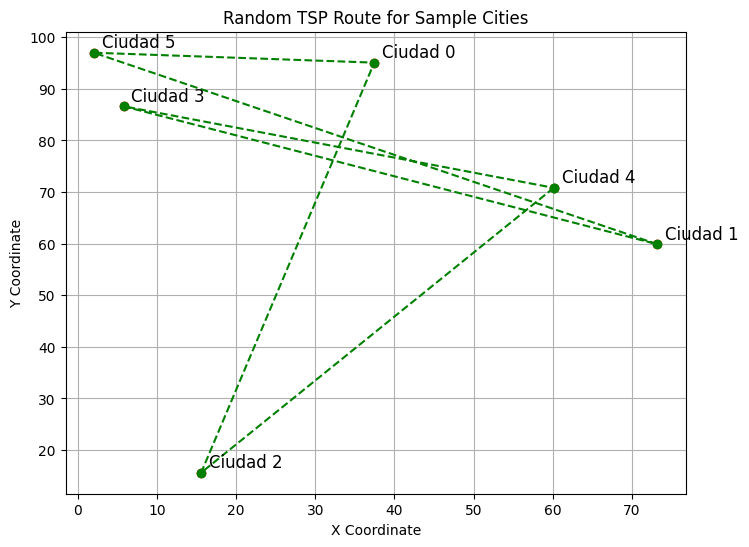

In [16]:
random_route = np.random.permutation(num_cities)
random_length = route_length(random_route, cities)

print("Random route:", random_route)
print("Random route length: {:.2f}".format(random_length))

plt.figure(figsize=(8, 6))
plt.scatter(cities[:, 0], cities[:, 1], c='red')
for i, (x, y) in enumerate(cities):
    plt.text(x + 1, y + 1, city_labels[i], fontsize=12)

route_cities = np.array([cities[i] for i in random_route] + [cities[random_route[0]]])
plt.plot(route_cities[:, 0], route_cities[:, 1], 'g--o')
plt.title("Random TSP Route for Sample Cities")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

## Solución y Visualización del Algoritmo TSP para un Número Incremental de Ciudades

Esta sección calcula la solución del algoritmo TSP para entre 3 y n ciudades, agregando una ciudad a la vez al conjunto existente, y visualiza la ruta óptima junto con el tiempo y el costo para cada caso.

[3, 4, 5, 6, 7, 8]
[1/6] ciudades=3 | tiempo=0.0000s | costo=205.24
[2/6] ciudades=4 | tiempo=0.0000s | costo=227.26
[3/6] ciudades=5 | tiempo=0.0040s | costo=227.35


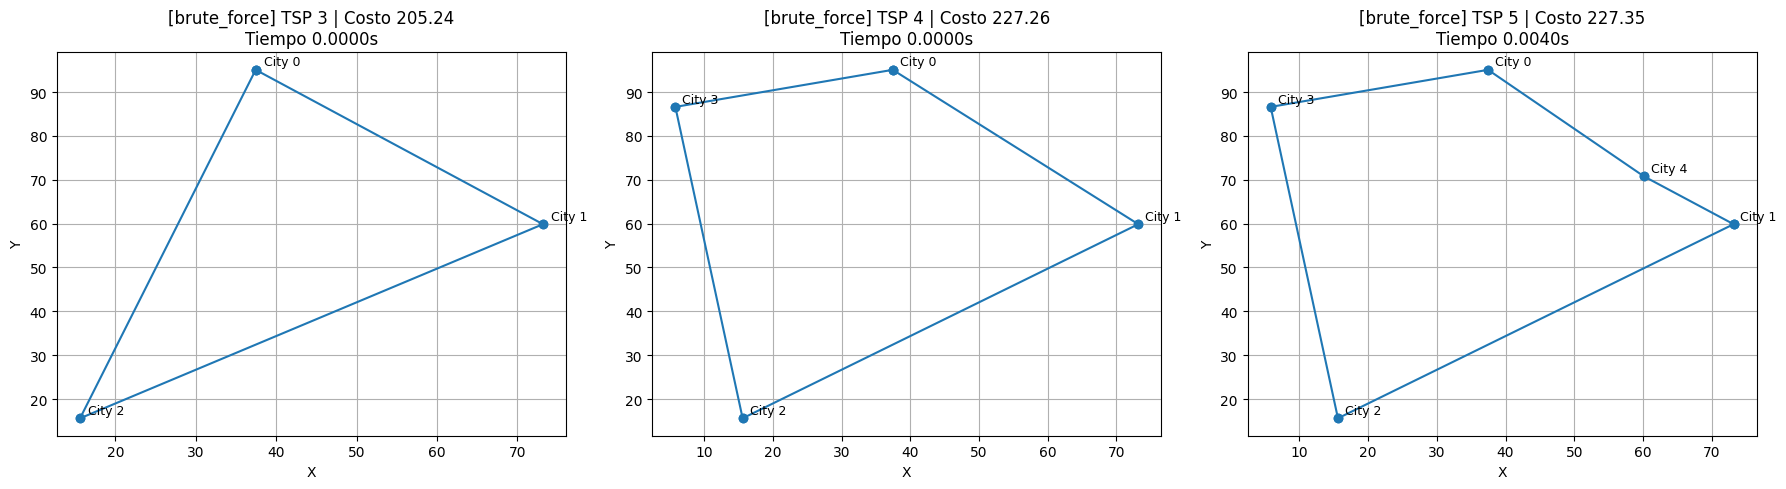

[4/6] ciudades=6 | tiempo=0.0191s | costo=241.07
[5/6] ciudades=7 | tiempo=0.1601s | costo=276.22
[6/6] ciudades=8 | tiempo=1.2881s | costo=277.23


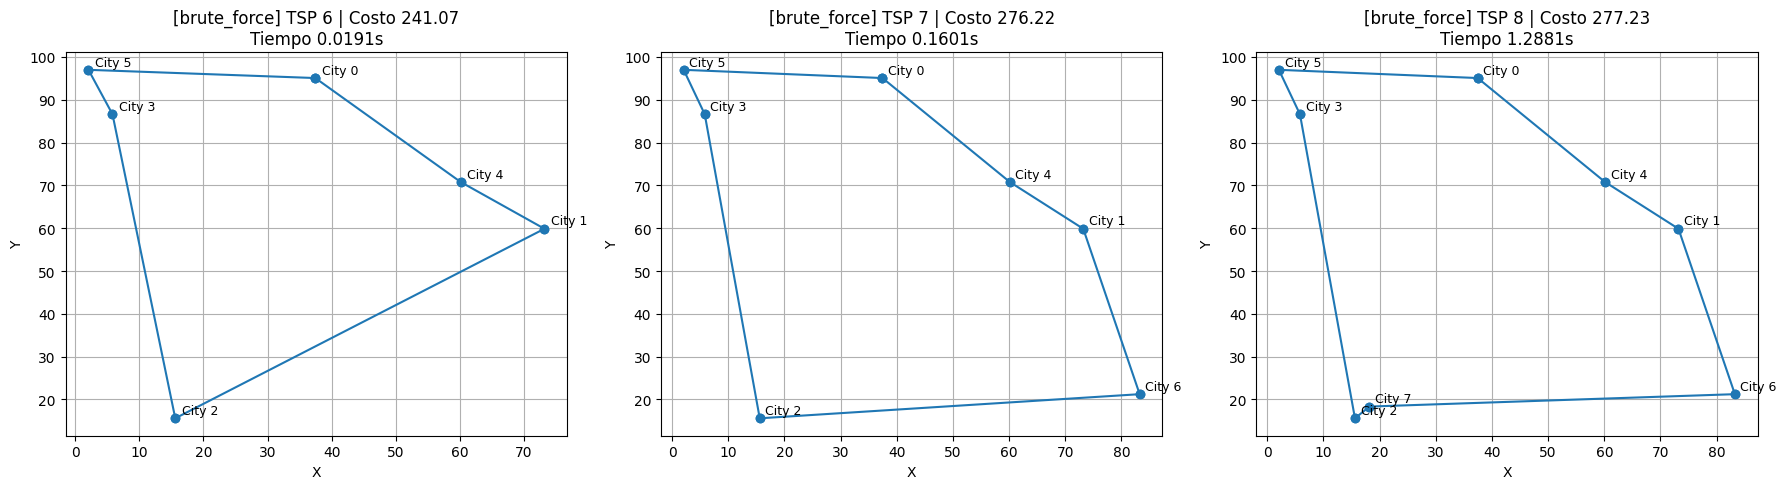


n | ruta                   | largo  | tiempo(s)
--+------------------------+--------+----------
3 | 0->1->2                | 205.24 | 0.0000   
4 | 0->1->2->3             | 227.26 | 0.0000   
5 | 1->4->0->3->2          | 227.35 | 0.0040   
6 | 0->4->1->2->3->5       | 241.07 | 0.0191   
7 | 0->4->1->6->2->3->5    | 276.22 | 0.1601   
8 | 0->5->3->2->7->6->1->4 | 277.23 | 1.2881   


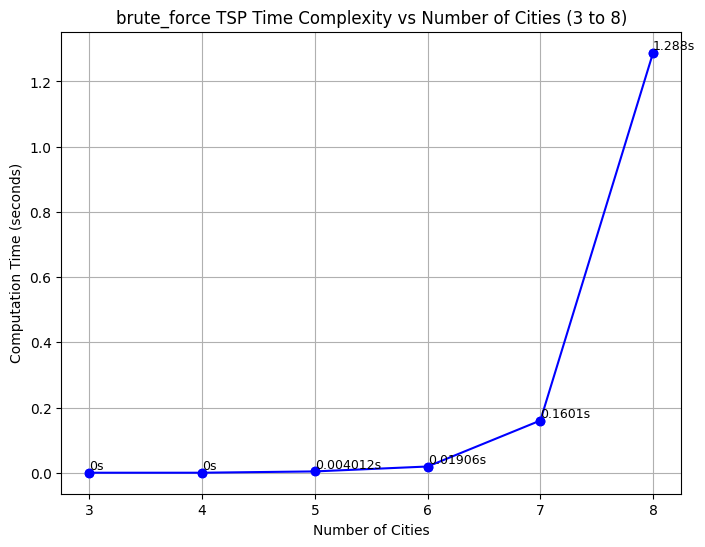

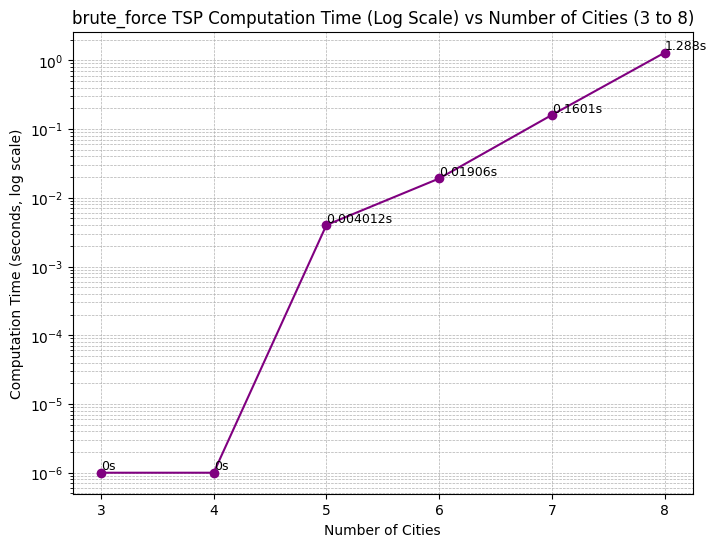

In [17]:
np.random.seed(42)

import time
algorithm=brute_force
max_cities = 8   
city_counts, solve_times,_ = run_n_cities(algorithm, max_cities)


## Ejercicio 1 - Held Karp
- Implemente la función de `held_karp_dist(dist)` la cual recibe como entrada una matriz de distancias y realice almenos la ejecución de 20 ciudades para su comparación
- Compare los resultados obtenidos con brute-force, tanto en tiempo como en calidad de la solución . Ambas son las mejores? si es asi justifique porque ocurre esto.

In [18]:
from scipy.spatial.distance import pdist, squareform
from itertools import combinations

def held_karp(cities, num_cities):
    dist = squareform(pdist(cities))
    return held_karp_dist(dist)

def held_karp_dist(dist: List[List[float]]) -> Tuple[float, List[int]]:
    """Solves the TSP using Held-Karp Dynamic Programming algorithm.
    This is an exact algorithm with O(n^2 * 2^n) time and space complexity.
    Suitable only for small n (n <= 20).

    Args: dist: 2D matrix (n x n) of costs between cities.
    Returns: Tuple: (minimum tour cost, tour as list of city indices)
    """
    n = len(dist)
    path = cities = list(range(len(dist)))
    min_cost = 1.0 

    if n <= 1:
        return (0.0, [0] if n == 1 else [])
    
    # DP[(mask, j)] = (costo, predecesor) del mejor camino 0 -> ... -> j
    dp = {}

    # casos base: {0, j}
    for j in range(1, n):
        mask = (1 << 0) | (1 << j)
        dp[(mask, j)] = (dist[0][j], 0)

    # subconjuntos crecientes que incluyen 0
    for m in range(3, n + 1):
        for subset in combinations(range(1, n), m - 1):
            mask = 1  # incluye 0
            for v in subset:
                mask |= 1 << v

            for j in subset:
                prev_mask = mask & ~(1 << j)
                best_cost, best_prev = float("inf"), -1
                for i in subset:
                    if i == j:
                        continue
                    c_prev, _ = dp[(prev_mask, i)]
                    cand = c_prev + dist[i][j]
                    if cand < best_cost:
                        best_cost, best_prev = cand, i
                dp[(mask, j)] = (best_cost, best_prev)

    # cerrar el ciclo a 0
    full_mask = (1 << n) - 1
    min_cost, last = float("inf"), -1  # <-- reutilizo min_cost
    for j in range(1, n):
        c, _ = dp[(full_mask, j)]
        c += dist[j][0]
        if c < min_cost:
            min_cost, last = c, j

    # reconstrucción de ruta (arranca en 0)
    route = [0]
    mask = full_mask
    j = last
    while j != 0:
        route.append(j)
        _, prev = dp[(mask, j)]
        mask &= ~(1 << j)
        j = prev
    
    path = route
    return min_cost, path


[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[1/18] ciudades=3 | tiempo=0.0000s | costo=205.24
[2/18] ciudades=4 | tiempo=0.0000s | costo=227.26
[3/18] ciudades=5 | tiempo=0.0000s | costo=227.35


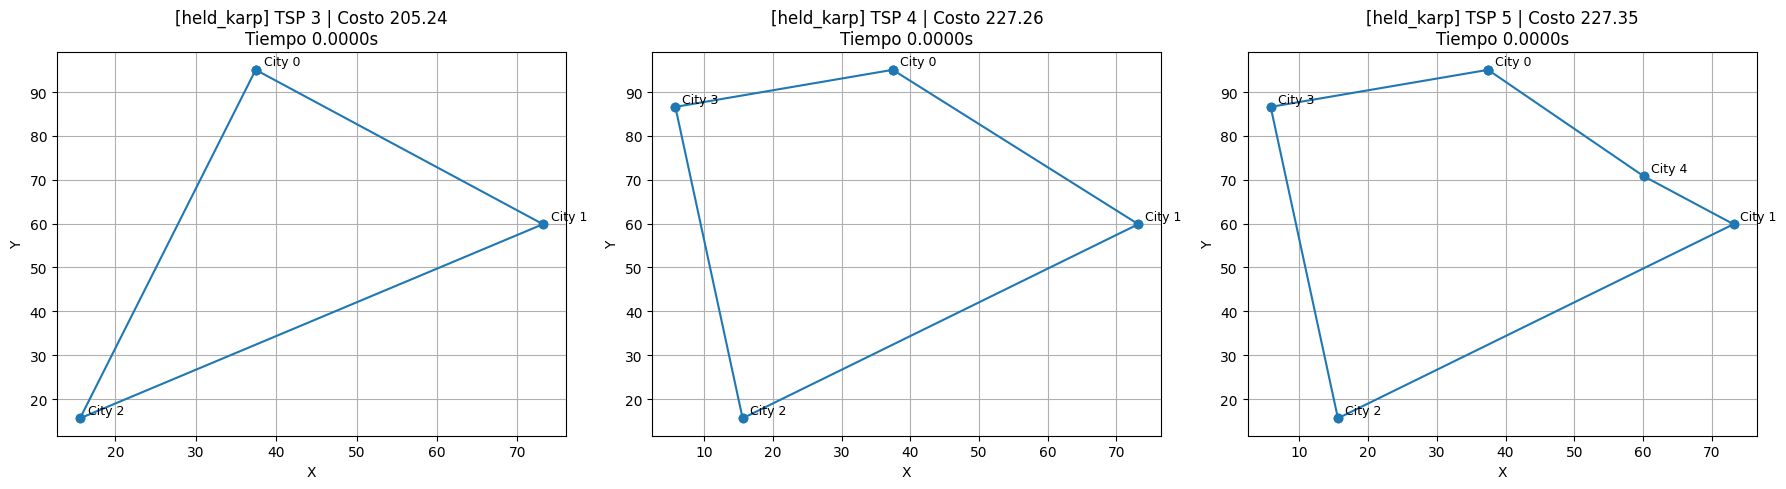

[4/18] ciudades=6 | tiempo=0.0009s | costo=241.07
[5/18] ciudades=7 | tiempo=0.0000s | costo=276.22
[6/18] ciudades=8 | tiempo=0.0029s | costo=277.23


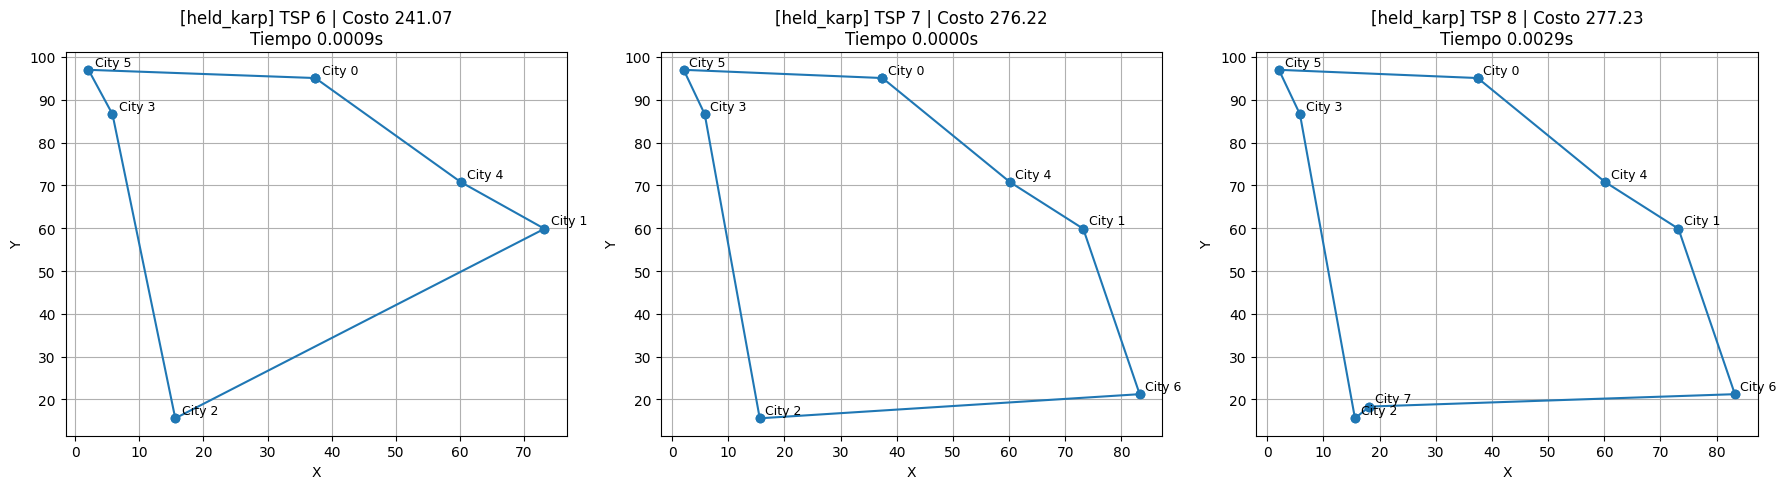

[7/18] ciudades=9 | tiempo=0.0030s | costo=286.65
[8/18] ciudades=10 | tiempo=0.0100s | costo=290.31
[9/18] ciudades=11 | tiempo=0.0193s | costo=296.25


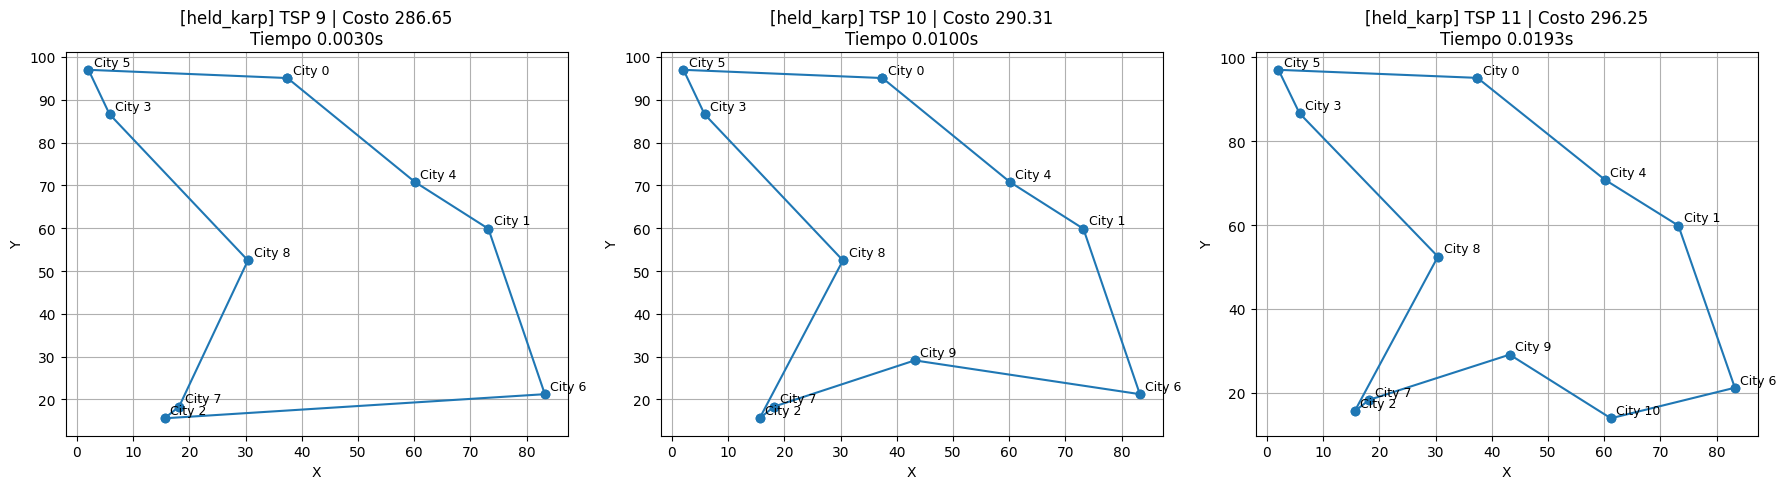

[10/18] ciudades=12 | tiempo=0.3189s | costo=297.25
[11/18] ciudades=13 | tiempo=0.1085s | costo=298.93
[12/18] ciudades=14 | tiempo=0.2373s | costo=305.29


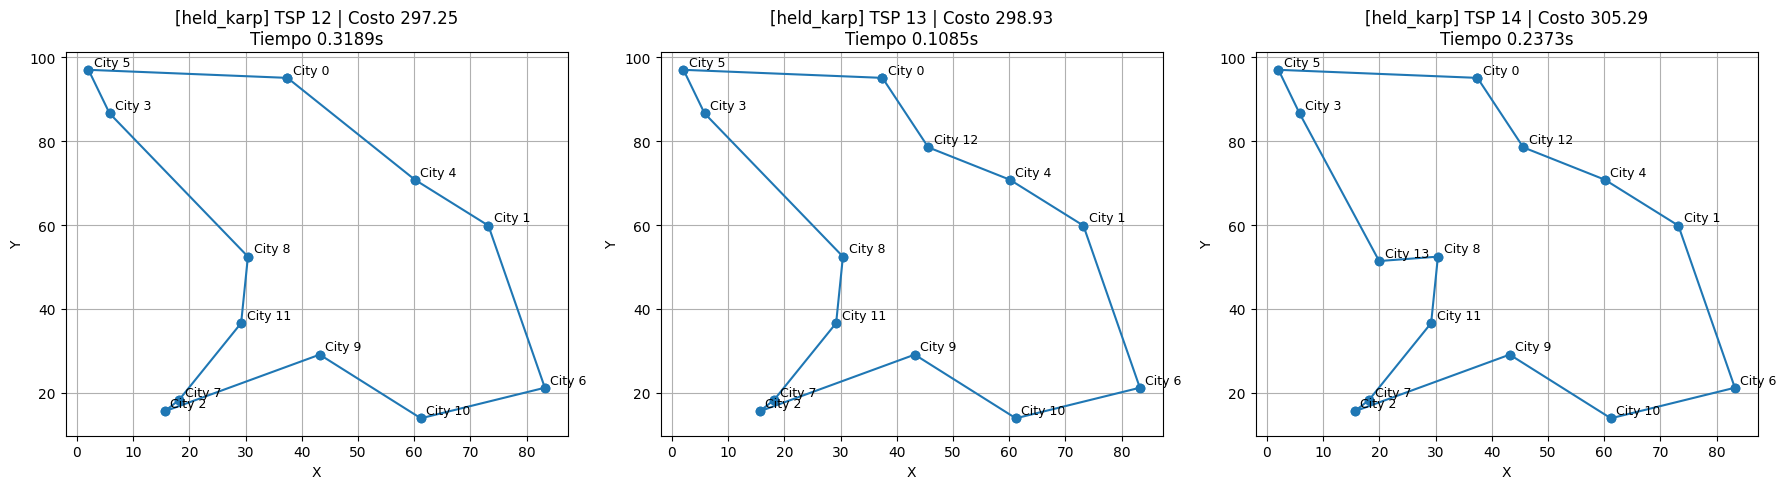

[13/18] ciudades=15 | tiempo=0.5534s | costo=320.53
[14/18] ciudades=16 | tiempo=1.4041s | costo=321.64
[15/18] ciudades=17 | tiempo=3.2646s | costo=322.07


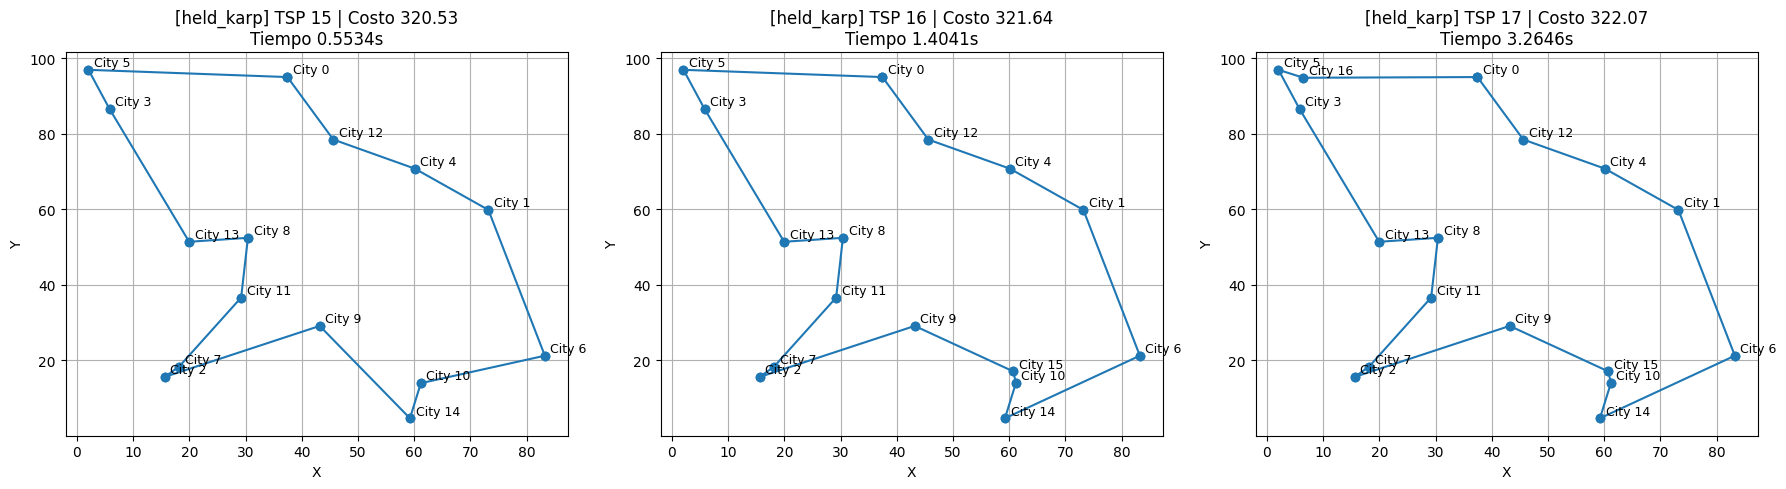

[16/18] ciudades=18 | tiempo=7.3282s | costo=374.21
[17/18] ciudades=19 | tiempo=15.5946s | costo=382.61
[18/18] ciudades=20 | tiempo=54.4039s | costo=386.43


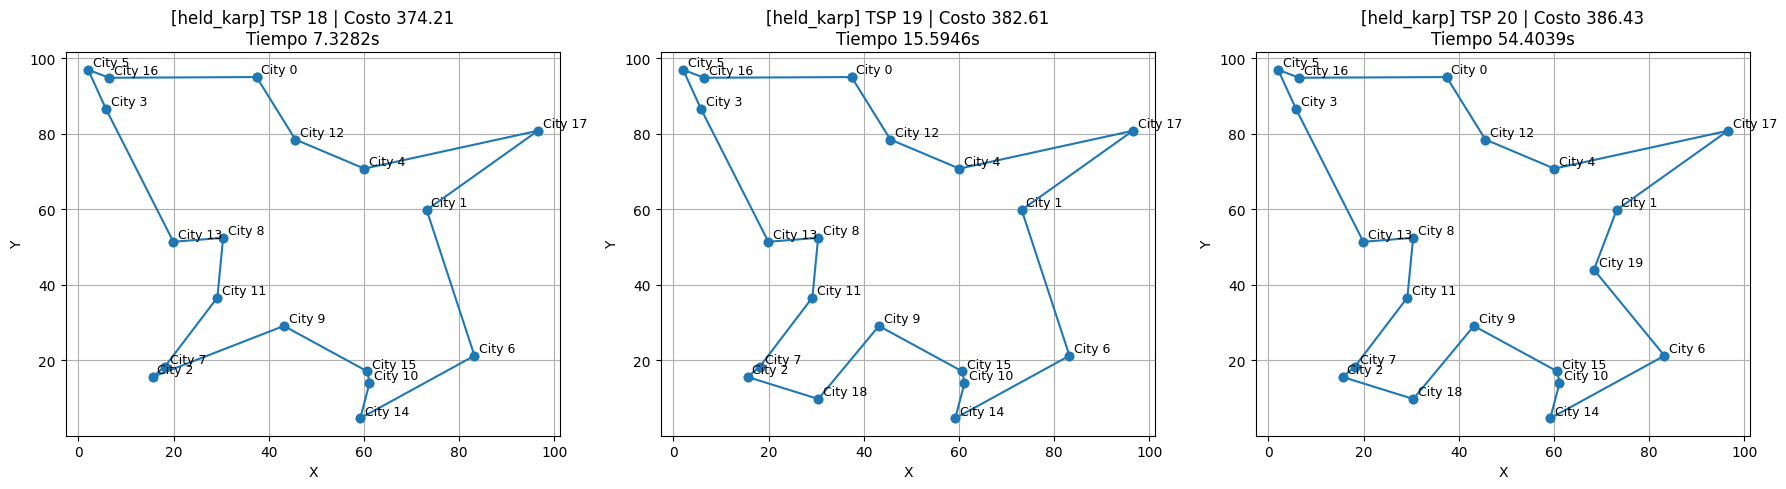


n  | ruta                                                                 | largo  | tiempo(s)
---+----------------------------------------------------------------------+--------+----------
3  | 0->2->1                                                              | 205.24 | 0.0000   
4  | 0->1->2->3                                                           | 227.26 | 0.0000   
5  | 0->3->2->1->4                                                        | 227.35 | 0.0000   
6  | 0->5->3->2->1->4                                                     | 241.07 | 0.0009   
7  | 0->4->1->6->2->3->5                                                  | 276.22 | 0.0000   
8  | 0->4->1->6->7->2->3->5                                               | 277.23 | 0.0029   
9  | 0->4->1->6->2->7->8->3->5                                            | 286.65 | 0.0030   
10 | 0->5->3->8->2->7->9->6->1->4                                         | 290.31 | 0.0100   
11 | 0->4->1->6->10->9->7->2->8->3->5            

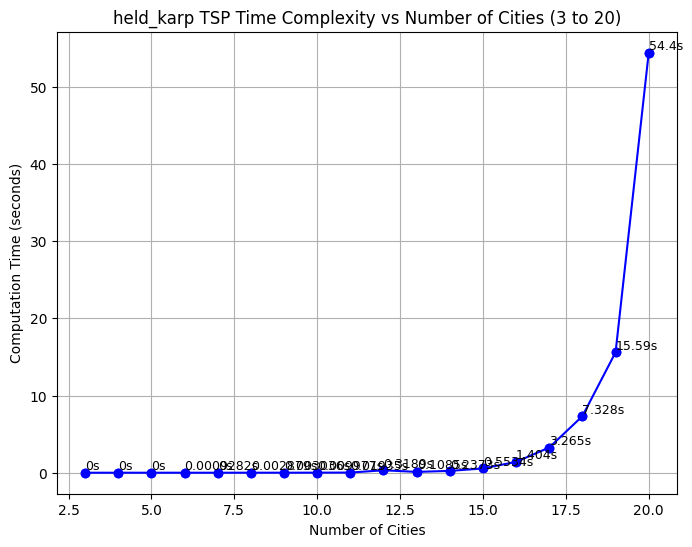

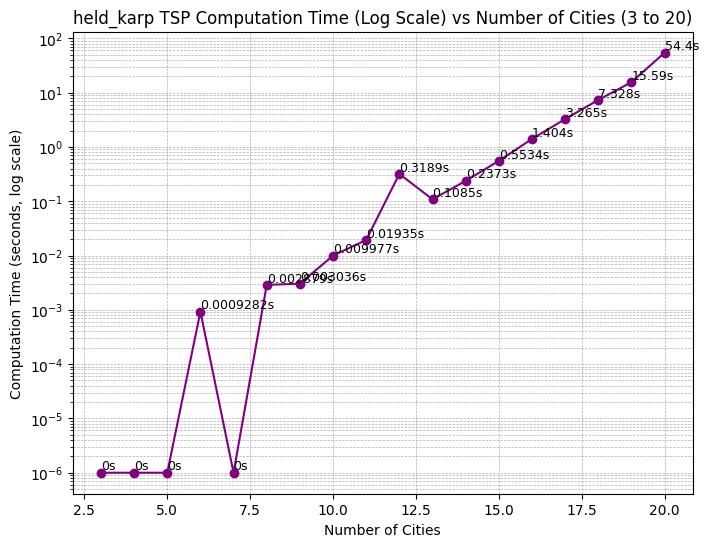

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] [0.0, 0.0, 0.0, 0.0009281635284423828, 0.0, 0.0028791427612304688, 0.0030357837677001953, 0.009976863861083984, 0.01934647560119629, 0.3188514709472656, 0.10850882530212402, 0.23731708526611328, 0.5533874034881592, 1.4040660858154297, 3.264598846435547, 7.328211069107056, 15.594552040100098, 54.403873682022095] [np.float64(205.23579819680498), np.float64(227.25986949326284), np.float64(227.34551867849092), np.float64(241.06807549059883), np.float64(276.21833744551475), np.float64(277.23241951682456), np.float64(286.6472235549413), np.float64(290.3067737777875), np.float64(296.25323192212375), np.float64(297.2509182121361), np.float64(298.93200692682495), np.float64(305.2866704174466), np.float64(320.5256656696074), np.float64(321.64480058108387), np.float64(322.0653025116671), np.float64(374.21046702908126), np.float64(382.61352369760635), np.float64(386.4296894765133)]
[3, 4, 5, 6, 7, 8, 9, 10]
[1/8] ciudades=3 | tiempo

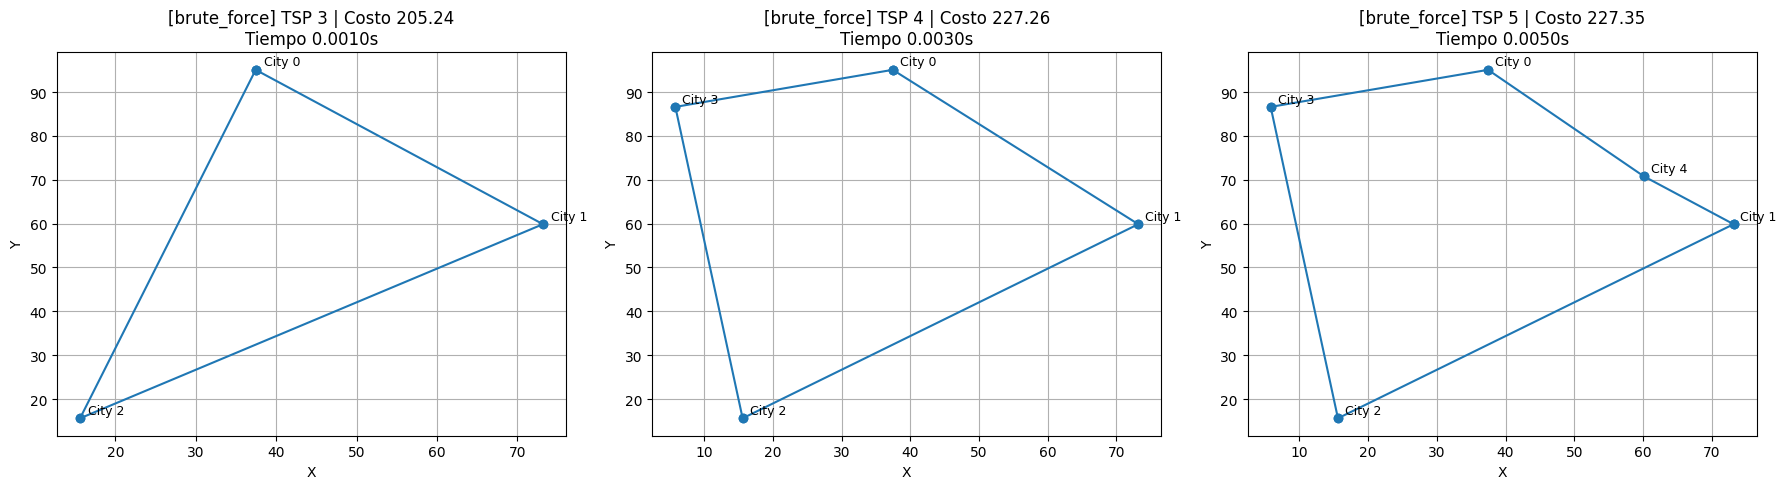

[4/8] ciudades=6 | tiempo=0.0771s | costo=241.07
[5/8] ciudades=7 | tiempo=0.5624s | costo=276.22
[6/8] ciudades=8 | tiempo=3.5625s | costo=277.23


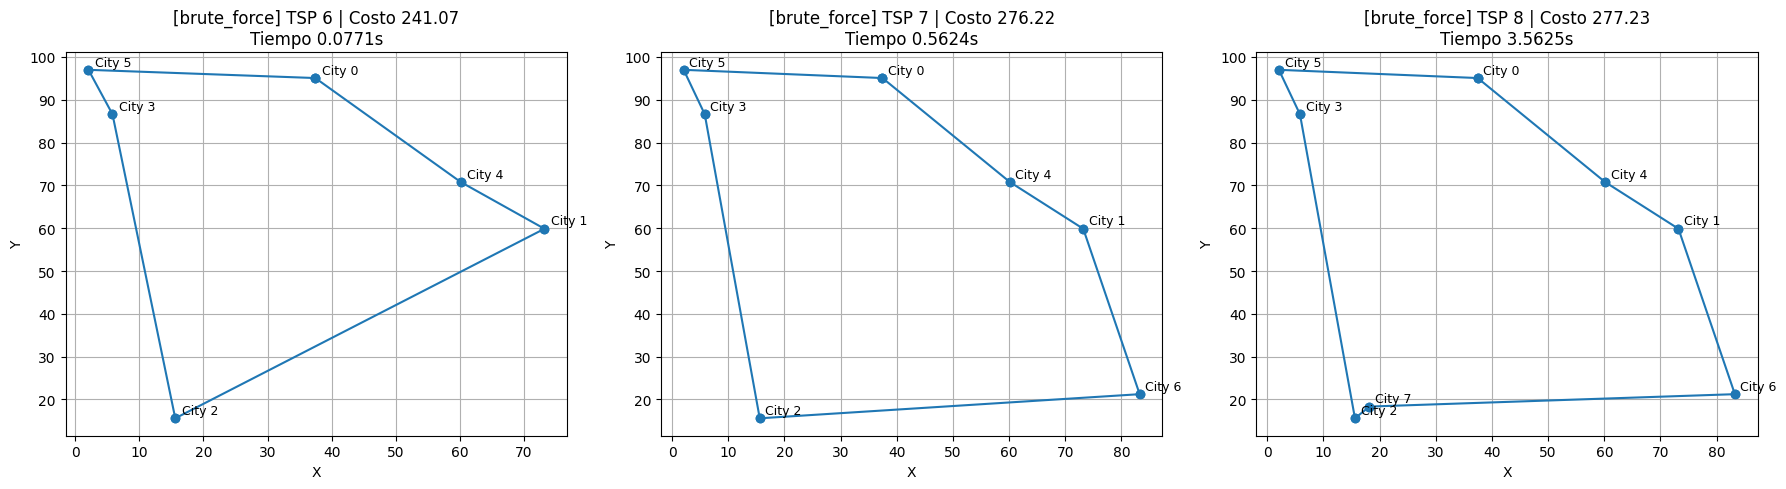

[7/8] ciudades=9 | tiempo=27.0372s | costo=286.65
[8/8] ciudades=10 | tiempo=264.2474s | costo=290.31


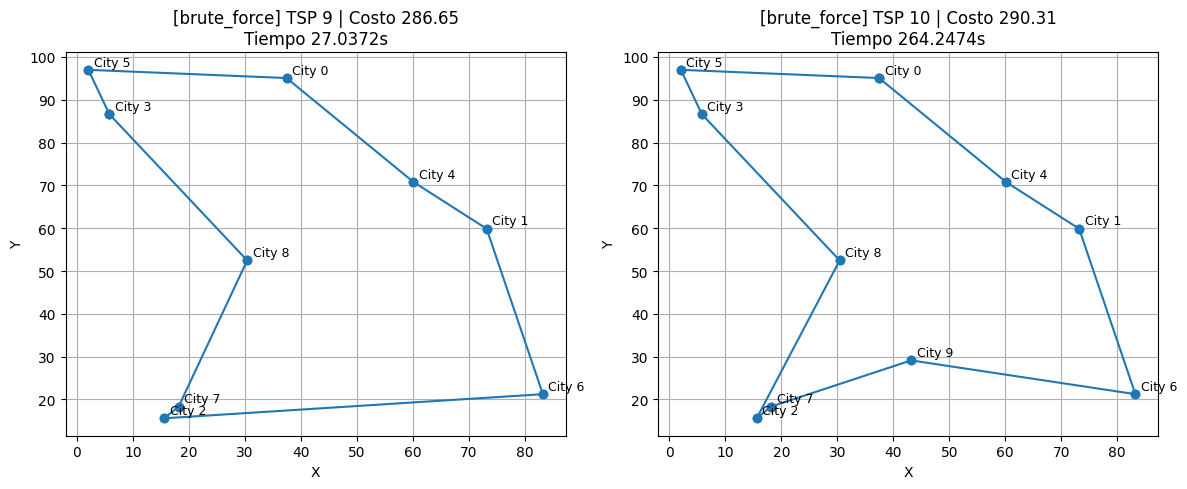


n  | ruta                         | largo  | tiempo(s)
---+------------------------------+--------+----------
3  | 0->1->2                      | 205.24 | 0.0010   
4  | 0->1->2->3                   | 227.26 | 0.0030   
5  | 1->4->0->3->2                | 227.35 | 0.0050   
6  | 0->4->1->2->3->5             | 241.07 | 0.0771   
7  | 0->4->1->6->2->3->5          | 276.22 | 0.5624   
8  | 0->5->3->2->7->6->1->4       | 277.23 | 3.5625   
9  | 3->8->7->2->6->1->4->0->5    | 286.65 | 27.0372  
10 | 0->4->1->6->9->7->2->8->3->5 | 290.31 | 264.2474 


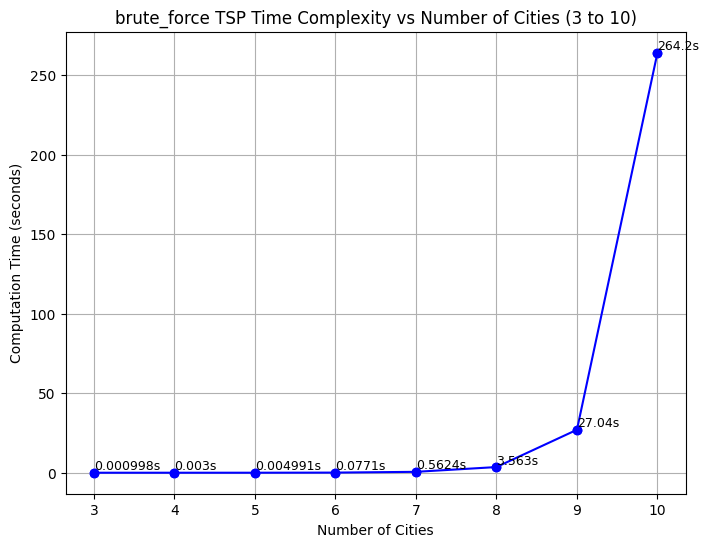

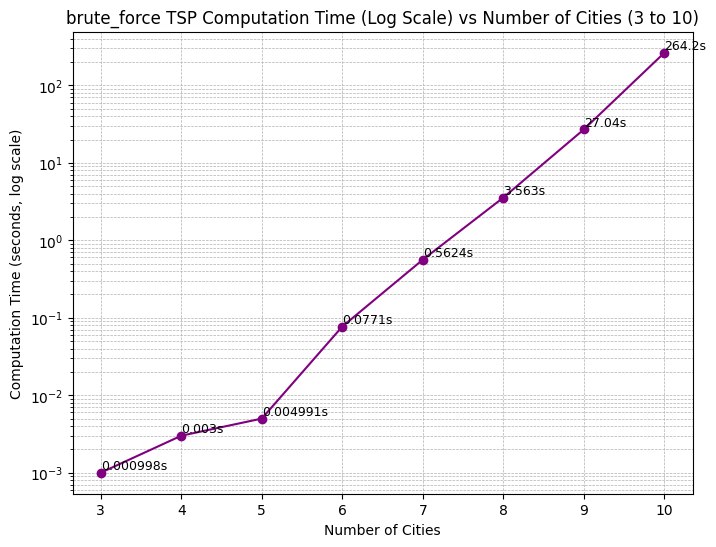

[3, 4, 5, 6, 7, 8, 9, 10] [0.0009980201721191406, 0.0029997825622558594, 0.004991054534912109, 0.07709646224975586, 0.5624256134033203, 3.5625040531158447, 27.03721046447754, 264.24742698669434] [np.float64(205.23579819680498), np.float64(227.25986949326284), np.float64(227.3455186784909), np.float64(241.06807549059883), np.float64(276.21833744551475), np.float64(277.23241951682456), np.float64(286.64722355494126), np.float64(290.3067737777875)]


In [23]:
np.random.seed(42)

import time
algorithm=held_karp
max_cities = 20  
city_counts, solve_times, best_costs = run_n_cities(algorithm, max_cities, show_plots=True)
print(city_counts, solve_times, best_costs)

#TODO Comparar con brute-force y justificar resultados (utilice un max_cities sugerido de 10).
max_cities = 10
city_counts, solve_times, best_costs = run_n_cities(brute_force, max_cities, show_plots=True)
print(city_counts, solve_times, best_costs)


[3, 4, 5, 6, 7, 8, 9, 10]
[1/8] ciudades=3 | tiempo=0.0010s | costo=205.24
[2/8] ciudades=4 | tiempo=0.0020s | costo=227.26
[3/8] ciudades=5 | tiempo=0.0070s | costo=227.35
[4/8] ciudades=6 | tiempo=0.0906s | costo=241.07
[5/8] ciudades=7 | tiempo=0.6280s | costo=276.22
[6/8] ciudades=8 | tiempo=1.2442s | costo=277.23
[7/8] ciudades=9 | tiempo=11.9967s | costo=286.65
[8/8] ciudades=10 | tiempo=131.2633s | costo=290.31

n  | ruta                         | largo  | tiempo(s)
---+------------------------------+--------+----------
3  | 0->1->2                      | 205.24 | 0.0010   
4  | 0->1->2->3                   | 227.26 | 0.0020   
5  | 1->4->0->3->2                | 227.35 | 0.0070   
6  | 0->4->1->2->3->5             | 241.07 | 0.0906   
7  | 0->4->1->6->2->3->5          | 276.22 | 0.6280   
8  | 0->5->3->2->7->6->1->4       | 277.23 | 1.2442   
9  | 3->8->7->2->6->1->4->0->5    | 286.65 | 11.9967  
10 | 0->4->1->6->9->7->2->8->3->5 | 290.31 | 131.2633 
[3, 4, 5, 6, 7, 8, 9, 10]
[

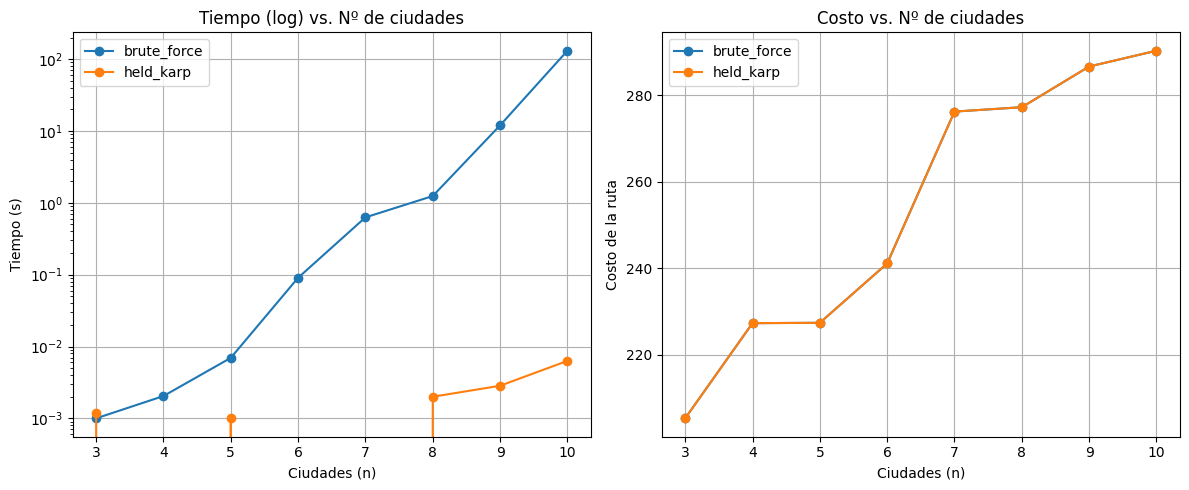

[('brute_force',
  [3, 4, 5, 6, 7, 8, 9, 10],
  [0.0009999275207519531,
   0.0020437240600585938,
   0.006952047348022461,
   0.09058547019958496,
   0.6280350685119629,
   1.244218349456787,
   11.99668002128601,
   131.2632553577423],
  [205.23579819680498,
   227.25986949326284,
   227.3455186784909,
   241.06807549059883,
   276.21833744551475,
   277.23241951682456,
   286.64722355494126,
   290.3067737777875]),
 ('held_karp',
  [3, 4, 5, 6, 7, 8, 9, 10],
  [0.0011723041534423828,
   0,
   0.0010080337524414062,
   0,
   0,
   0.0019981861114501953,
   0.0028421878814697266,
   0.006307125091552734],
  [205.23579819680498,
   227.25986949326284,
   227.34551867849092,
   241.06807549059883,
   276.21833744551475,
   277.23241951682456,
   286.6472235549413,
   290.3067737777875])]

In [24]:
plot_algorithms_times_costs([brute_force, held_karp], max_cities, start_at=3)

En la gráfica de la izquierda brute-force crece de forma explosiva a medida que aumenta el número de ciudades. El tiempo pasa de ser prácticamente inmediato con 3–5 ciudades a superar los 100 segundos en 10 ciudades, lo que refleja la complejidad factorial del método (O(n!)). En contraste, el algoritmo de Held–Karp mantiene tiempos muy bajos incluso con 10 ciudades. Esto se debe a que su complejidad es O(n*2^n), que sigue siendo exponencial, pero mucho más eficiente que enumerar todas las permutaciones. Es decir, held–Karp es mucho más escalable y práctico que brute-force, permitiendo resolver instancias más grandes en un tiempo razonable.

En la otra gráfica el costo de la ruta óptima encontrado por cada algoritmo es igual para brute-force y Held–Karp en todos los casos. Confirmando que ambos algoritmos llegan siempre al óptimo global.

## Tarea 2 - Comparación metaheuristicas con held-kap
Realice el experiemento con held-karp y utilice los algoritmos de hill_climbing y simulated anneling en comparación.
- Cual es la diferencia empirica en el tiempo de ejecución.
- Todos los caminos encontrados resuelven el problema? Si es asi, todas las soluciones son óptimas? Justifique
- En caso de no ser optimas las soluciones realice un grafico demostrando la diferencia de costo por optimizar no optimizado. es decir la distancia entre el optimo y la distancia en la solución algoritmica. 

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[1/18] ciudades=3 | tiempo=0.0000s | costo=205.24
[2/18] ciudades=4 | tiempo=0.0010s | costo=227.26
[3/18] ciudades=5 | tiempo=0.0010s | costo=227.35
[4/18] ciudades=6 | tiempo=0.0000s | costo=241.07
[5/18] ciudades=7 | tiempo=0.0020s | costo=276.22
[6/18] ciudades=8 | tiempo=0.0034s | costo=277.23
[7/18] ciudades=9 | tiempo=0.0109s | costo=286.65
[8/18] ciudades=10 | tiempo=0.0227s | costo=290.31
[9/18] ciudades=11 | tiempo=0.0450s | costo=296.25
[10/18] ciudades=12 | tiempo=0.0922s | costo=297.25
[11/18] ciudades=13 | tiempo=0.2243s | costo=298.93
[12/18] ciudades=14 | tiempo=0.6006s | costo=305.29
[13/18] ciudades=15 | tiempo=1.2766s | costo=320.53
[14/18] ciudades=16 | tiempo=2.9931s | costo=321.64
[15/18] ciudades=17 | tiempo=3.7708s | costo=322.07
[16/18] ciudades=18 | tiempo=7.7238s | costo=374.21
[17/18] ciudades=19 | tiempo=16.2603s | costo=382.61
[18/18] ciudades=20 | tiempo=37.6993s | costo=386.43

n  | ruta  

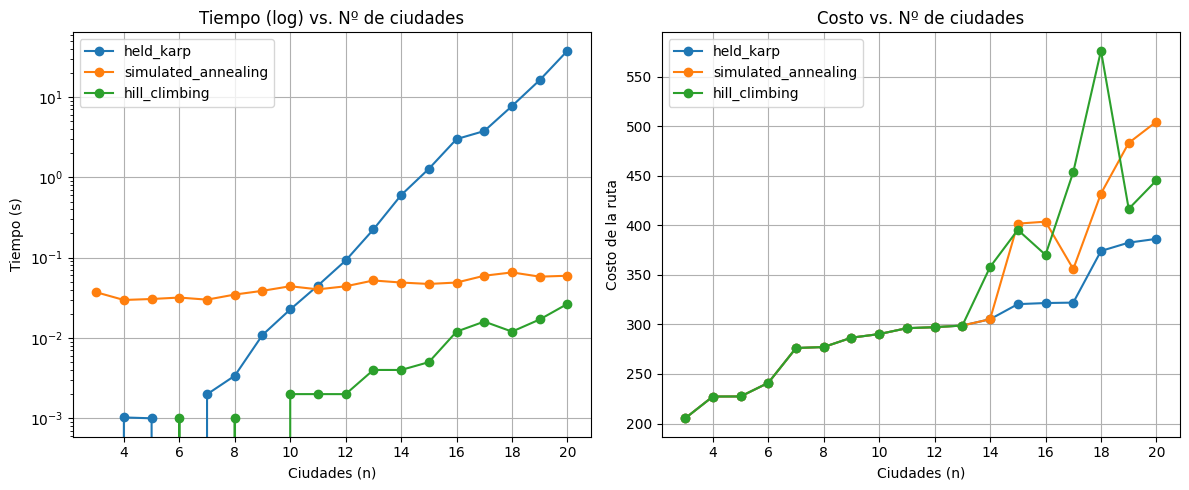

In [25]:
algs = [held_karp, simulated_annealing, hill_climbing]
series = plot_algorithms_times_costs(algs, max_cities=20) ##A efectos practico se recomienda bajar a n=20 ya que esto podria demorar mucho 

1. Held–Karp escala exponencialmente y su tiempo crece rápido a partir de 10 ciudades, mientras que hill climbing y simulated annealing se mantienen casi constantes y muy inferiores en costo computacional.

2. Todas las técnicas encuentran rutas factibles, pero solo Held–Karp garantiza siempre la solución óptima. Porque hill climbing tiende a quedarse en mínimos locales y simulated annealing mejora los resultados al escapar de ellos, aunque sin alcanzar siempre el óptimo.


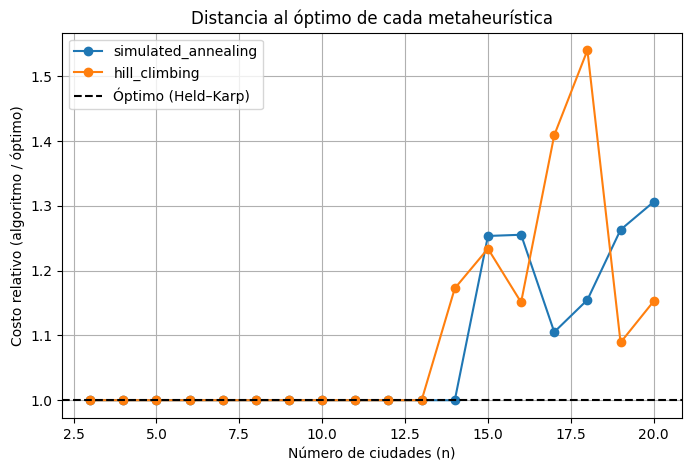

In [ ]:
# 3. Diferencias de Costos
# Las metaheurísticas ofrecen soluciones muy rápidas, 
# pero a costa de perder optimalidad en instancias grandes.

# Extraer los costos óptimos
city_counts_opt, best_costs_opt = None, None
for label, city_counts, solve_times, best_costs in series:
    if label == "held_karp":
        city_counts_opt = city_counts
        best_costs_opt = best_costs
        break


opt_map = {n: c for n, c in zip(city_counts_opt, best_costs_opt)}

# Grafica costo relativo (algoritmo / óptimo)
plt.figure(figsize=(8, 5))
for label, city_counts, solve_times, best_costs in series:
    if label == "held_karp":
        continue
    rel_costs = [cost / opt_map[n] for n, cost in zip(city_counts, best_costs)]
    plt.plot(city_counts, rel_costs, marker='o', label=label)

plt.axhline(1.0, ls='--', color='black', label='Óptimo (Held–Karp)')
plt.xlabel("Número de ciudades (n)")
plt.ylabel("Costo relativo (algoritmo / óptimo)")
plt.title("Distancia al óptimo de cada metaheurística")
plt.grid(True)
plt.legend()
plt.show()